<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/CNN2_Optimzier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

다음은 저수준의 텐서플로우 API를 사용해서 CNN을 구현하는 방법이다. 저수준 API이므로 tf.Variable을 사용해야 한다.

In [ ]:
import numpy as np
import tensorflow as tf

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)





In [ ]:
# x는 4만8천개 샘플에 높이 28 넓이 28 데이터이다. 28개 데이터가 한개의 array가 되고 이를 다시 28개씩 묶어놓은 것이 한개의 샘플로 구성된다.
# 흑백이므로 채널은 1개이지만 원래 데이터에는 표시가 되어있지 않다.
# 데이터는 0~255로 구성되며 이는 각 pixel의 흑색의 강도를 의미한다.
x_train.shape 

(48000, 28, 28)

In [ ]:
y_train # 0부터 9사이의 숫자이다.

array([6, 6, 3, ..., 4, 7, 1], dtype=uint8)

x_train을 채널이 하나인 매트릭스로 reshaping (-1,28,28,1) 시킨다. 이는 각 한개의 데이터로 한개의 array를 만들로 이를 다시 28개로 묶고, 다시 한번 28개씩 묶으면 하나의 샘플이 된다. 만약 채널이 3개였다면 구성이 달라졌을 것이다.

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

x_train = x_train / 255  # 데이터는 0~255로 구성되며를 전체를 255로 나누어 데이터를 정규화 시킨다.
x_val = x_val / 255

아래는 텐서의 shape를 알아보기 위해서 작성한 코드이다.

In [ ]:
g = tf.initializers.glorot_uniform()
conv_w = tf.Variable(g((3, 3, 1, 10)))
conv_w.shape

TensorShape([3, 3, 1, 10])

In [ ]:
c_out = tf.nn.conv2d(x_train, conv_w, strides=1, padding='SAME')
p1 = tf.nn.max_pool2d(c_out, ksize=2, strides=2, padding='VALID')

In [ ]:
print(c_out.shape)
print(p1.shape)

(48000, 28, 28, 10)
(48000, 14, 14, 10)


In [ ]:
f_out = tf.reshape(p1, [x_train.shape[0], -1])
f_out.shape

TensorShape([48000, 1960])

In [ ]:
y_train_encoded.shape

(48000, 10)

**다음부터 CNN의 class code이다.**

In [ ]:

class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  # 합성곱의 커널 개수, CNN에서는 합성곱층의 신경망 노드를 커널로 명칭
        self.kernel_size = 3        # 커널 크기, 합성곱층에서 사용할 커널(가중치 메트릭스)의 크기를 의미한다.
        self.optimizer = None       # 옵티마이저
        self.conv_w = None          # 합성곱 층의 가중치
        self.conv_b = None          # 합성곱 층의 절편
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size  # 배치 크기
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        self.lr = learning_rate     # 학습률

    def forpass(self, x):
        # 3x3 합성곱 연산을 수행합니다. 한 칸씩 (stride)이동하되, 원래 input의 높이와 넓이와 동일하게 same 패딩을 적용
        # x.shape = (48000,28,28,1), conv_w.shape = (3,3,1,10) 이고 두개를 same padding으로 합성곱하면 (48000, 28, 28, 10) 
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # 렐루 활성화 함수를 적용합니다.
        r_out = tf.nn.relu(c_out)
        # 2x2 최대 풀링을 적용합니다. Valid 패팅은 pooling 매트릭스가 이동 하면서 원래 Input에 끝까지 다다르면 패딩을 멈추는 방식이다.
        # 여기서는 28*28 input을 2*2 pooling으로 2칸식 이동하므로 14번 이동하면 멈추게 되는 방식이다. 2*2칸에서 최대값만 가져오는 것이므로 weight가 없다.
        # 여기서 p_out.shape = (48000, 14, 14, 10) 이다. 크기가 반으로 작아진다.
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다. 완전연결층으로 데이터를 전달하기 위함이다.
        # f_out.shape는 (48000, 1960) 이다. 1960 = 14*14*10 즉 모든 샘플데이터를 한개의 열로 만든다. 
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다 매트릭스 (샘플수, 14*14*10) (14*14*10, 10) 간 곱이다. 
        a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
        z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform() # glorot 초기화를 적용한다.
        # 합성곱층의 커널의 크기는 3*3이고 채널을 흑백으로 1이고, 커널수는 10개이다.따라서 conv_w.shape는 (3,3,1,10)이다.
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다. y_train_encode의 shape는 (48000, 10)이다
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size                   # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                    # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다. loss를 특정 weights_list에서 미분한 미분값을 grads로 저정한다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))
   
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

코드의 실행에 있어서 커널의 개수, 히든 레이어의 unit수는 변경이 가능하다.

In [ ]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=50)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

In [ ]:
import matplotlib.pyplot as plt

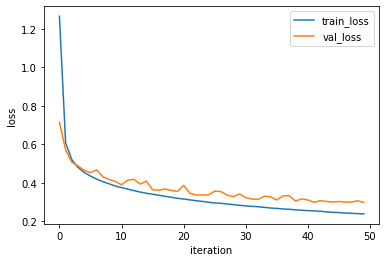

In [ ]:
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
cn.predict(x_train)

array([6, 0, 3, ..., 4, 7, 1])

In [ ]:
cn.score(x_train, y_train_encoded)

0.90025

**다음은 고수준 API를 적용하여 CNN를 진행한다.**

In [ ]:
import numpy as np
import tensorflow as tf

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

x_train = x_train / 255  # 데이터는 0~255로 구성되며를 전체를 255로 나누어 데이터를 정규화 시킨다.
x_val = x_val / 255


In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

def basic_cnn():
    model = Sequential()

    model.add(Conv2D(input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]), filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    # prior layer should be flattend to be connected to dense layers
    model.add(Flatten())
    # dense layer with 50 neurons
    model.add(Dense(50, activation = 'relu'))
    # final layer with 10 neurons to classify the instances
    model.add(Dense(10, activation = 'softmax'))

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

model = basic_cnn()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 10)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                98050     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
Total params: 98,660
Trainable params: 98,660
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(x_train, y_train_encoded, batch_size = 128, validation_split = 0.2, epochs = 30)



Train on 38400 samples, validate on 9600 samples
Epoch 1/30
38400/38400 [==============================] - 12s 313us/step - loss: 0.5967 - accuracy: 0.7971 - val_loss: 0.4226 - val_accuracy: 0.8514
Epoch 2/30
38400/38400 [==============================] - 12s 307us/step - loss: 0.3742 - accuracy: 0.8684 - val_loss: 0.3704 - val_accuracy: 0.8693
Epoch 3/30
38400/38400 [==============================] - 12s 309us/step - loss: 0.3292 - accuracy: 0.8843 - val_loss: 0.3361 - val_accuracy: 0.8820
Epoch 4/30
38400/38400 [==============================] - 12s 305us/step - loss: 0.3001 - accuracy: 0.8924 - val_loss: 0.3284 - val_accuracy: 0.8832
Epoch 5/30
38400/38400 [==============================] - 12s 307us/step - loss: 0.2831 - accuracy: 0.9000 - val_loss: 0.3133 - val_accuracy: 0.8871
Epoch 6/30
38400/38400 [==============================] - 12s 317us/step - loss: 0.2634 - accuracy: 0.9056 - val_loss: 0.2995 - val_accuracy: 0.8910
Epoch 7/30
38400/38400 [==============================] -

KeyError: ignored

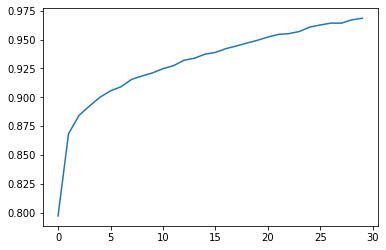

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.show()

In [ ]:
print(history.history['accuracy'][29])

0.9685417


**다음은 고수준 API를 사용하지만 CNN이 아닌 ANN사용한 예이다.**

In [32]:
import numpy as np
import tensorflow as tf

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [2]:
x_train.shape

(48000, 28, 28)

In [7]:
set(y_train) # 10개 숫자이다.

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [3]:
import matplotlib.pyplot as plt

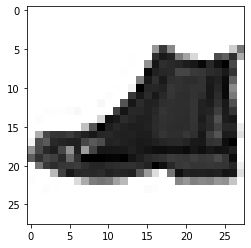

In [33]:
digit = x_train[6]

plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [34]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='sigmoid', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

In [35]:
network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [36]:
network.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
x_train = x_train/255 # 정규화
x_train = x_train.reshape((-1, 28*28)) # 첫째 층에 일렬로 들어갈 수 있도록 입력 데이터 모양을 바꾼다

In [38]:
from keras.utils import to_categorical

y_train = to_categorical(y_train) # softmax에 맞게 onehot 코딩, y가 10개 data 형태이므로
print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [39]:
fitshory = network.fit(x_train, y_train, epochs=30, batch_size=128)

Epoch 1/30
48000/48000 [==============================] - 4s 73us/step - loss: 0.6087 - accuracy: 0.7910
Epoch 2/30
48000/48000 [==============================] - 3s 70us/step - loss: 0.4371 - accuracy: 0.8439
Epoch 3/30
48000/48000 [==============================] - 3s 70us/step - loss: 0.3996 - accuracy: 0.8571
Epoch 4/30
48000/48000 [==============================] - 3s 71us/step - loss: 0.3744 - accuracy: 0.8653
Epoch 5/30
48000/48000 [==============================] - 3s 69us/step - loss: 0.3579 - accuracy: 0.8707
Epoch 6/30
48000/48000 [==============================] - 3s 70us/step - loss: 0.3390 - accuracy: 0.8766
Epoch 7/30
48000/48000 [==============================] - 3s 70us/step - loss: 0.3251 - accuracy: 0.8821
Epoch 8/30
48000/48000 [==============================] - 3s 71us/step - loss: 0.3126 - accuracy: 0.8854
Epoch 9/30
48000/48000 [==============================] - 3s 71us/step - loss: 0.3022 - accuracy: 0.8903
Epoch 10/30
48000/48000 [==============================

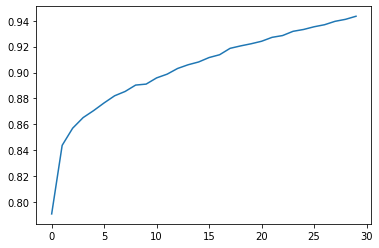

In [40]:
plt.plot(fitshory.history['accuracy'])
plt.show()

In [41]:
fitshory.history['accuracy'][-1]

0.94341666

**이것은 참조 문서이므로 Skip한다**

두 번째는 텐서플로 실행방법이 완전 변했습니다. 원래는 그래프를 만들고 placeholder로 입력을 설정합니다. 그다음 session을 생성하고 run(feed_dict=)처럼 입력값을 placeholder의 위치로 넣어서 실행합니다.

 

이제 즉시 실행(eager execution)이 적용되어 placeholder, session, feed_dict가 없어졌습니다. 대신 function이란 개념이 생기고, function_name(input)처럼 함수처럼 만들어 실행이 가능합니다. 아래 페이지를 보면 2.0으로 컨버팅하는 방법이 자세히 나와있습니다

In [ ]:
W = tf.Variable(tf.ones(shape=(2,2)), name="W")
b = tf.Variable(tf.zeros(shape=(2)), name="b")

print(W.shape)

def forward(x):
  return W * x + b

a= np.array([[1.0],[1.0]], dtype='f')
print("a shape is ", a.shape)

out_a = forward(a)
print(out_a)

(2, 2)
a shape is  (2, 1)
tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


아래는 저수준의 텐서플로 API를 사용하여 자동미분을 사용하여 최적값을 구하는 예이다.

In [ ]:
import tensorflow as tf
import numpy as np

x_train = np.arange(10).reshape((10,1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

print(x_train.shape)
print(y_train.shape)



(10, 1)
(10,)


tape.gradient(mean_cost, [self.w, self.b])는 mean_cost를 self.w, self.b로 각각 미분한 값을 가지게 된다.

그리고 appy_gradients(zip(grads, [self.w, self.b]))은 미분값과 각 w, b값을 튜플로 만들어 optimizer에 적용시킨다. 그러면 각 optimizer의 특성에 따라서 w, b값을 update시킨다.

In [ ]:
class TfLinreg():

  def __init__(self, lr=0.01):
    self.w = tf.Variable(tf.zeros(shape=(1)))
    self.b = tf.Variable(tf.zeros(shape=(1)))
    self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

  def fit(self, x, y, num_epochs=10):
    training_costs = []
    for step in range(num_epochs):
      with tf.GradientTape() as tape:
        z_net = self.w * x + self.b  # 여기서 z_net.shape = (10,1)
        z_net = tf.reshape(z_net, [-1]) # 여기서 z_net.shape = (10,)이고 y_train과 shape를 맞추기 위해서 변경한 것이다
        sqr_errors = tf.square(y - z_net)
        mean_cost = tf.reduce_mean(sqr_errors)

      grads = tape.gradient(mean_cost, [self.w, self.b])
      self.optimizer.apply_gradients(zip(grads, [self.w, self.b]))
      training_costs.append(mean_cost.numpy())
      weight_list = [self.w, self.b]
    return training_costs, weight_list

In [ ]:
lrmodel = TfLinreg()

In [ ]:
training_costs, weight_list = lrmodel.fit(x_train, y_train)

In [ ]:
print(training_costs)
print("w is ", weight_list[0][0].numpy())

[32.431, 6.0113096, 1.446125, 0.65659344, 0.5193632, 0.4948352, 0.48978764, 0.48811454, 0.48703355, 0.48606348]
w is  1.0273236


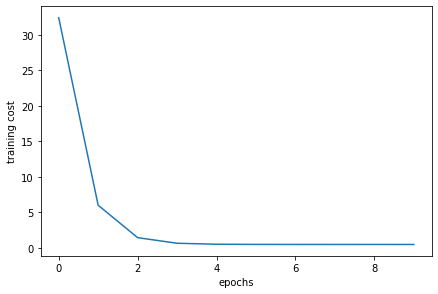

In [ ]:
import matplotlib.pyplot as plt
plt.plot(training_costs)
plt.tight_layout()
plt.xlabel("epochs")
plt.ylabel("training cost")
plt.show()